In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import kagglehub
import os

print("Downloading dataset via kagglehub...")

# Use the provided path from the kagglehub output:
path = "/kaggle/input/superstore-dataset-final"

try:
    file_name = 'Sample - Superstore.csv' # Check this against the actual file name in the folder
    full_file_path = os.path.join(path, file_name)

    print(f"Attempting to load file from: {full_file_path}")

    # Load the CSV into a Pandas DataFrame
    df_ss = pd.read_csv(full_file_path, encoding='latin1', parse_dates=['Order Date'])
    print("\nSuperstore Dataset loaded successfully!")

except FileNotFoundError:
    # Fallback/alternative name check (sometimes it's just 'superstore.csv')
    file_name = 'Superstore.csv'
    full_file_path = os.path.join(path, file_name)
    df_ss = pd.read_csv(full_file_path, encoding='latin1', parse_dates=['Order Date'])
    print(f"\nSuperstore Dataset loaded successfully using alternative name: {file_name}!")
except Exception as e:
    print(f"Critical error loading file. Check the file name inside the '{path}' directory.")
    raise e # Raise the error to stop execution if it still fails

# Filter columns needed for forecasting/analysis
df_ss = df_ss[['Order Date', 'Sales', 'Region', 'Category']]

Attempting to load file from: /kaggle/input/superstore-dataset-final/Sample - Superstore.csv

Superstore Dataset loaded successfully!


In [2]:
# DATA CLEANING & AGGREGATION

# One-Hot Encoding for XGBoost features
df_encoded = pd.get_dummies(df_ss, columns=['Region', 'Category'], drop_first=True)

# Group and aggregate daily sales and the encoded feature counts
df_final = df_encoded.groupby('Order Date').agg({
    'Sales': 'sum',
    # Summing 0/1 indicator = count of feature presence on that day
    'Region_East': 'sum',
    'Region_South': 'sum',
    'Region_West': 'sum',
    'Category_Office Supplies': 'sum',
    'Category_Technology': 'sum'
}).reset_index()

# Rename columns for Prophet compatibility
df_final.columns = ['ds', 'y'] + list(df_final.columns[2:])

# Fill missing days (Time Series requirement)
df_final = df_final.set_index('ds').resample('D').asfreq(fill_value=0).reset_index()
df_final['y'] = df_final['y'].fillna(0) # Ensure sales is 0 for non-sales days
# Fill encoded columns with 0 for missing days
df_final[df_final.columns[2:]] = df_final[df_final.columns[2:]].fillna(0)

print("\nDaily Sales Time Series created and features encoded.")
print(df_final.head())


Daily Sales Time Series created and features encoded.
          ds         y  Region_East  Region_South  Region_West  \
0 2014-01-03    16.448            0             0            0   
1 2014-01-04   288.060            0             0            0   
2 2014-01-05    19.536            1             0            0   
3 2014-01-06  4407.100            0             8            1   
4 2014-01-07    87.158            0             0            0   

   Category_Office Supplies  Category_Technology  
0                         1                    0  
1                         3                    0  
2                         1                    0  
3                         6                    2  
4                         1                    0  


In [3]:
# FEATURE ENGINEERING

# Calendar Features
print("\nCreating Calendar Features...")
df_final['year'] = df_final['ds'].dt.year
df_final['month'] = df_final['ds'].dt.month
df_final['dayofweek'] = df_final['ds'].dt.dayofweek
df_final['dayofyear'] = df_final['ds'].dt.dayofyear
df_final['quarter'] = df_final['ds'].dt.quarter

# Lag & Rolling Features
print("Creating Lag and Rolling Features...")
df_final['lag_7'] = df_final['y'].shift(7)
df_final['lag_365'] = df_final['y'].shift(365)
df_final['rolling_mean_30'] = df_final['y'].rolling(window=30, min_periods=1).mean().shift(1)

# Handle initial NaNs created by shifting/rolling
df_final = df_final.fillna(0)

print("\nFeature Engineering Complete. Final DataFrame Head:")
print(df_final.head())


Creating Calendar Features...
Creating Lag and Rolling Features...

Feature Engineering Complete. Final DataFrame Head:
          ds         y  Region_East  Region_South  Region_West  \
0 2014-01-03    16.448            0             0            0   
1 2014-01-04   288.060            0             0            0   
2 2014-01-05    19.536            1             0            0   
3 2014-01-06  4407.100            0             8            1   
4 2014-01-07    87.158            0             0            0   

   Category_Office Supplies  Category_Technology  year  month  dayofweek  \
0                         1                    0  2014      1          4   
1                         3                    0  2014      1          5   
2                         1                    0  2014      1          6   
3                         6                    2  2014      1          0   
4                         1                    0  2014      1          1   

   dayofyear  quarter  la


 Training Prophet Model with Extra Regressors...

Prophet Model MAPE (Regressors Added): 87.93%


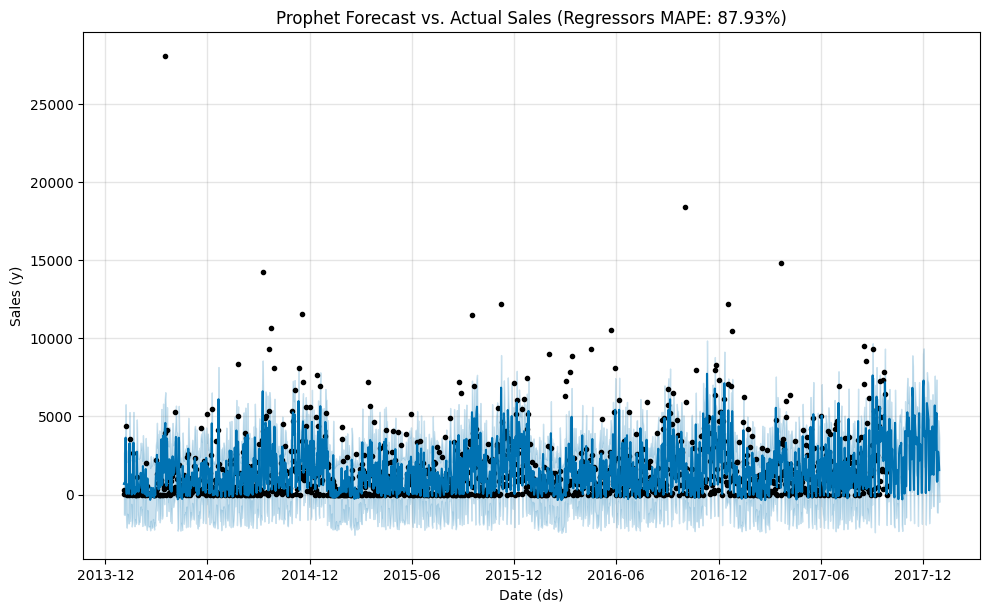


Forecast successfully generated with improved regressors.


In [4]:
# PROPHET MODEL TRAINING & FORECASTING
print("\n Training Prophet Model with Extra Regressors...")

# Define Extra Regressors (The features engineered for XGBoost)
EXOGENOUS_FEATURES = [
    'Region_East', 'Region_South', 'Region_West',
    'Category_Office Supplies', 'Category_Technology',
    'lag_7', 'lag_365', 'rolling_mean_30'
]

# Split Data (Using 90 days for testing/validation)
TEST_PERIOD = 90
TRAIN_SIZE = len(df_final) - TEST_PERIOD
df_train = df_final.iloc[:TRAIN_SIZE].copy()
df_test = df_final.iloc[TRAIN_SIZE:].copy()

# Instantiate and fit the model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
m.add_country_holidays(country_name='US')

for feature in EXOGENOUS_FEATURES:
    m.add_regressor(feature)

# Fit the model
m.fit(df_train)

# Create Future Dates and Predict

future = df_final.copy()
forecast = m.predict(future)

# Evaluation on the Test Set (Filter Applied)
y_true_full = df_test['y'].values
# Select the predicted values corresponding to the test period
y_pred_full = forecast['yhat'].iloc[TRAIN_SIZE:TRAIN_SIZE + TEST_PERIOD].values

non_zero_indices = y_true_full > 0
y_true_filtered = y_true_full[non_zero_indices]
y_pred_filtered = y_pred_full[non_zero_indices]

if len(y_true_filtered) > 0:
    mape_filtered = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
    print(f"\nProphet Model MAPE (Regressors Added): {mape_filtered*100:.2f}%")
else:
    mape_filtered = np.nan

# Visualization
fig = m.plot(forecast)
plt.title(f"Prophet Forecast vs. Actual Sales (Regressors MAPE: {mape_filtered*100 if not np.isnan(mape_filtered) else 'N/A':.2f}%)")
plt.xlabel("Date (ds)")
plt.ylabel("Sales (y)")
plt.show()

# Extract the final forecast (90 days)
forecast_90_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-TEST_PERIOD:]
forecast_90_days.rename(columns={'yhat': 'Forecasted_Sales'}, inplace=True)
print("\nForecast successfully generated with improved regressors.")

In [5]:
# XGBOOST DATA PREPARATION
print("\n Preparing Data for XGBoost...")

# Define Target and Feature Columns
TARGET = 'y'
# Include all engineered features (Calendar, Lag, Rolling) and encoded features
FEATURES = [
    'year', 'month', 'dayofweek', 'dayofyear', 'quarter',
    'Region_East', 'Region_South', 'Region_West',
    'Category_Office Supplies', 'Category_Technology',
    'lag_7', 'lag_365', 'rolling_mean_30'
]

# Split Data (Time Series Split)
TEST_PERIOD = 90
TRAIN_SIZE = len(df_final) - TEST_PERIOD

# X (Features) and y (Target)
X = df_final[FEATURES]
y = df_final[TARGET]

# Split using time series structure
X_train, X_test = X.iloc[:TRAIN_SIZE], X.iloc[TRAIN_SIZE:]
y_train, y_test = y.iloc[:TRAIN_SIZE], y.iloc[TRAIN_SIZE:]

print(f"XGBoost training data shape: {X_train.shape}")


 Preparing Data for XGBoost...
XGBoost training data shape: (1368, 13)


In [13]:
# XGBOOST TRAINING & EVALUATION (FINAL SIMPLIFICATION)
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np

print("Training XGBoost Regressor...")

# Instantiate the model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, # Runs for the full 1000 iterations
    learning_rate=0.01,
    max_depth=10,
    random_state=42,
    tree_method='hist'
)

# Train the model (No eval_set, callbacks, or early_stopping_rounds)
xgb_model.fit(X_train, y_train)

# Predict on the Test Set
# Use the full range of estimators since there is no 'best_iteration'
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluation (Filter applied)
y_true_full = y_test.values
y_pred_full = y_pred_xgb_test

# Filter out days where Actual Sales (y_true) were zero
non_zero_indices = y_true_full > 0
y_true_filtered = y_true_full[non_zero_indices]
y_pred_filtered = y_pred_full[non_zero_indices]

if len(y_true_filtered) > 0:
    mape_xgb_filtered = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
    print(f"\n XGBoost Model MAPE (Filtered Validation Set): {mape_xgb_filtered*100:.2f}%")
else:
    mape_xgb_filtered = np.nan
    print("\nWarning: No sales found in the test period for filtered MAPE calculation.")

# Generate 90-day Forecast
# X_forecast should use the original X defined in the previous cell's Step 1
X_forecast = X.iloc[-TEST_PERIOD:]
# Predict using the full model
forecast_values_xgb = xgb_model.predict(X_forecast)

# Create the final forecast dataframe
forecast_xgb_90_days = pd.DataFrame({
    'ds': df_final['ds'].iloc[-TEST_PERIOD:],
    'Forecasted_Sales_XGB': forecast_values_xgb
})

print("\nXGBoost forecast successfully generated.")

Training XGBoost Regressor...

 XGBoost Model MAPE (Filtered Validation Set): 120.80%

XGBoost forecast successfully generated.


In [14]:
# DATA EXPORT
from google.colab import files
import pandas as pd

# The required dataframes are df_final (Historical Data) and forecast_90_days (Prophet Forecast)

# Prepare Historical Data for Export
# Includes date, actual sales ('y' renamed to 'Actual_Sales'), and features for filtering
df_historical_export = df_final.copy()
df_historical_export.rename(columns={'y': 'Actual_Sales'}, inplace=True)

# Export Historical Data
historical_filename = 'Historical_Sales_Data.csv'
df_historical_export.to_csv(historical_filename, index=False)
files.download(historical_filename)
print(f"File '{historical_filename}' prepared for download.")

#  Export Forecast Data (Using the superior Prophet forecast)
forecast_filename = 'Sales_Forecast_90Days.csv'
# Assuming 'forecast_90_days' holds the Prophet output from the successful run
try:
    forecast_90_days.to_csv(forecast_filename, index=False)
    files.download(forecast_filename)
    print(f"File '{forecast_filename}' prepared for download.")
except NameError:
    # This block executes if the Prophet output variable was overwritten or cleared
    print("Error: forecast_90_days not found. Please re-run the final Prophet cell before exporting.")

print("\n\n*** Data preparation and modeling completed. Please download the two CSV files and proceed to Power BI Desktop. ***")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'Historical_Sales_Data.csv' prepared for download.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'Sales_Forecast_90Days.csv' prepared for download.


*** Data preparation and modeling completed. Please download the two CSV files and proceed to Power BI Desktop. ***


In [16]:
import pandas as pd

# FIX HISTORICAL SALES DATASET

# Load historical file
historical = pd.read_csv("/content/Historical_Sales_Data.csv")

# Rename important columns
historical = historical.rename(columns={
    "ds": "Order_Date",
    "Actual_Sales": "Sales"
})

# Create Region column from dummy variables
def get_region(row):
    if row.get("Region_East", 0) == 1:
        return "East"
    if row.get("Region_South", 0) == 1:
        return "South"
    if row.get("Region_West", 0) == 1:
        return "West"
    return "Central"   # fallback if no region is marked

historical["Region"] = historical.apply(get_region, axis=1)

# Create Category column
def get_category(row):
    if row.get("Category_Office Supplies", 0) > 0:
        return "Office Supplies"
    if row.get("Category_Technology", 0) > 0:
        return "Technology"
    return "Furniture"  # fallback

historical["Category"] = historical.apply(get_category, axis=1)

# Remove ML-feature columns
cols_to_drop = [
    "Region_East", "Region_South", "Region_West",
    "Category_Office Supplies", "Category_Technology",
    "lag_7", "lag_365", "rolling_mean_30"
]

historical = historical.drop(columns=[c for c in cols_to_drop if c in historical.columns])

# Add missing Power BI columns (blank)
historical["Profit"] = None
historical["Quantity"] = None
historical["State"] = None
historical["Segment"] = None
historical["Sub_Category"] = None

# Export cleaned file
historical.to_csv("/content/New_Historical_Sales_Data.csv", index=False)
print("Historical dataset fixed and saved as New_Historical_Sales_Data.csv")


# FIX SALES FORECAST (90-DAYS) DATASET


forecast = pd.read_csv("/content/Sales_Forecast_90Days.csv")

# Rename date & forecast column
forecast = forecast.rename(columns={
    "ds": "Forecast_Date",
    "Forecasted_Sales": "Forecast_Sales"
})

# Add optional blank fields for alignment with historical dataset
forecast["Region"] = None
forecast["Category"] = None
forecast["Profit_Forecast"] = None
forecast["Quantity_Forecast"] = None

# Export cleaned forecast file
forecast.to_csv("/content/New_Sales_Forecast_90Days.csv", index=False)
print("Forecast dataset fixed and saved as New_Sales_Forecast_90Days.csv")


Historical dataset fixed and saved as New_Historical_Sales_Data.csv
Forecast dataset fixed and saved as New_Sales_Forecast_90Days.csv
